# 3_run_all — End-to-End Pipeline

Questo notebook esegue l'intera pipeline **Scrape → Core Prep → MARS Ranking → Report Excel**.

**Contenuto**:
- Sezioni di `1_scrape_core_preview.ipynb` (scraping & core prep)
- Sezioni di `2_core_mars_preview.ipynb` (MARS, ranking e report)

⚠️ *Nota*: le celle sono state mantenute nell'ordine originale dei due notebook per massima compatibilità.


---

## Parte 1 — Scrape & Core Prep (da `1_scrape_core_preview.ipynb`)

# Ranking Limitless — Notebook Unico (D1 + D2/D3 + Validazione)

Questo notebook guida l'esecuzione end‑to‑end:

1) **Scraping (D1)**: decklist e matchups da Limitless (con cache 12h).
2) **Core (D2/D3)**: consolidamento (max N), alias, matrici W/L/T, WR direzionale e filtro NaN.
3) **Validazione**: controlli su WR e n_dir (coerenza W+L, simmetria, somma 100).

Gli output sono salvati sotto `outputs/` secondo il contratto stabilito.

> **Nota**: i notebook sono pensati per interfacciarsi ai moduli nella cartella `scraper/`, `core/`, `utils/`. Assicurati di eseguire questo notebook dalla **root del progetto**.

In [18]:
import logging

# 1) azzera gli handler duplicati di Jupyter ed imposta un’unica configurazione
logging.basicConfig(
    level=logging.INFO,           # livello generale del progetto
    format="%(levelname)s:%(name)s:%(message)s",
    force=True                    # 👈 IMPORTANTISSIMO in Jupyter per evitare duplicazioni
)

# 2) silenzia SOLO il logger di rete
logging.getLogger("ptcgp.net").setLevel(logging.WARNING)

# 3) opzionale: riduci rumore di webdriver-manager / selenium
logging.getLogger("WDM").setLevel(logging.WARNING)
logging.getLogger("selenium").setLevel(logging.WARNING)

# 4) se vuoi vedere più diagnostica del tuo codice ma non il traffico rete:
logging.getLogger("ptcgp").setLevel(logging.DEBUG)   # tuo codice
logging.getLogger("utils.io").setLevel(logging.INFO) # lascia i "CSV aggiornato" se ti servono


In [19]:
# Setup base e import dei moduli
from pathlib import Path
import logging
import pandas as pd

from utils.io import init_paths, _dest, write_csv_versioned, save_plot_timestamped
from scraper.decklist import scrape_decklist_html, parse_decklist_table, filter_top_meta, LIMITLESS_DECKS_URL
from scraper.matchups import to_matchup_url, scrape_matchups
from scraper.session import make_session
from core.normalize import load_alias_map, build_alias_index
from core.consolidate import maxN_flat, apply_alias_and_aggregate, build_score_table_filtered
from core.matrices import topmeta_post_alias, build_matrices, n_dir_from_WL
from core.nan_filter import filter_wr_nan_iterative

# ⚠️ NON richiamare basicConfig: già impostato in cella 1 con force=True
log = logging.getLogger("ptcgp")

BASE = Path.cwd()
paths = init_paths(BASE)
paths


Paths(base=WindowsPath('c:/Users/visen/OneDrive/Documenti/Archivio/Pokèmon/PTCGP/DataAnalysis/ptcgp_ranking'), outputs=WindowsPath('c:/Users/visen/OneDrive/Documenti/Archivio/Pokèmon/PTCGP/DataAnalysis/ptcgp_ranking/outputs'), cache=WindowsPath('c:/Users/visen/OneDrive/Documenti/Archivio/Pokèmon/PTCGP/DataAnalysis/ptcgp_ranking/cache/requests'), logs=WindowsPath('c:/Users/visen/OneDrive/Documenti/Archivio/Pokèmon/PTCGP/DataAnalysis/ptcgp_ranking/logs'))

In [20]:
# Garantisci file di configurazione minimi (alias_map.json e config.yaml) e carica CFG
cfg_dir = BASE / "config"
cfg_dir.mkdir(parents=True, exist_ok=True)

alias_json = cfg_dir / "alias_map.json"
if not alias_json.exists():
    alias_json.write_text("{}\n", encoding="utf-8")
    log.warning("[init] creato config/alias_map.json vuoto — nessun alias verrà applicato finché non lo compili.")

yaml_file = cfg_dir / "config.yaml"
if not yaml_file.exists():
    yaml_file.write_text("# config placeholder\n", encoding="utf-8")
    log.info("[init] creato config/config.yaml placeholder")

# Lettura della config (come facevi prima)
import yaml  # se non fosse installato, aggiungi 'pyyaml' al venv/requirements
with open(yaml_file, "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f) or {}
log.info("Config loaded from %s", yaml_file)

# (facoltativo) Allinea livelli di log alla config
lvl = (CFG.get("logging", {}).get("level", "INFO") or "INFO").upper()
logging.getLogger("ptcgp").setLevel(getattr(logging, lvl, logging.INFO))
logging.getLogger("utils.io").setLevel(logging.INFO)


INFO:ptcgp:Config loaded from c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\config\config.yaml


## D1 — Scraping decklist e matchups

- Usa Selenium per la pagina **Decks** (cache 12h lato HTML).
- Converte in tabella e filtra il **Top-meta (80%)**.
- Costruisce le URL `/matchups` e scarica tutte le pagine dei deck top.
- Scrive:
  - `outputs/Decklists/raw/decklist_raw_*latest.csv`
  - `outputs/Decklists/top_meta/top_meta_decklist_*latest.csv`
  - `outputs/MatchupData/raw/matchup_raw_*latest.csv`

In [21]:
# Esecuzione D1 — scraping + salvataggi raw (parametri presi da CFG)

# --- Parametri da config.yaml ---
scr_cfg   = CFG.get("scraping", {}) if "CFG" in globals() else {}
top_cfg   = CFG.get("top_meta", {}) if "CFG" in globals() else {}

DECKS_URL    = scr_cfg.get("decks_url", LIMITLESS_DECKS_URL)
TTL_MIN      = int(scr_cfg.get("cache_ttl_min", 720))
FORCE_REFRESH= bool(scr_cfg.get("force_refresh", False))
HEADLESS     = bool((scr_cfg.get("selenium") or {}).get("headless", True))
RATE_LIMIT   = float(scr_cfg.get("request_delay_sec", 5.0))
TOP_THRESH   = float(top_cfg.get("threshold_pct", 80.0))

log.info("[scrape] decks_url=%s | ttl_min=%s | headless=%s | force_refresh=%s | rate_limit=%.2fs | top_thresh=%.1f%%",
         DECKS_URL, TTL_MIN, HEADLESS, FORCE_REFRESH, RATE_LIMIT, TOP_THRESH)

# --- Decklist page ---
html, from_cache = scrape_decklist_html(
    DECKS_URL,
    cache_dir=paths.cache, ttl_minutes=TTL_MIN,
    force_refresh=FORCE_REFRESH, headless=HEADLESS
)
df_decklist = parse_decklist_table(html)

out1 = write_csv_versioned(
    df_decklist.reset_index(),
    _dest(paths, "decklist_raw"),
    "decklist_raw",
    changed=(not from_cache),
    index=False
)
log.info("Decklist rows=%d | saved=%s", len(df_decklist), out1)

# --- Top-meta + URL matchups ---
df_top = filter_top_meta(df_decklist, threshold_pct=TOP_THRESH).copy()
df_top["Matchup URL"] = df_top["URL"].map(to_matchup_url)

out2 = write_csv_versioned(
    df_top,
    _dest(paths, "top_meta_decklist"),
    "top_meta_decklist",
    changed=(not from_cache),
    index=False
)
log.info("Top-meta rows=%d | saved=%s", len(df_top), out2)

# --- Scarica matchups per tutti i deck top ---
urls = [(r["Deck"], r["Matchup URL"]) for _, r in df_top[["Deck","Matchup URL"]].dropna().iterrows()]
if not urls:
    raise RuntimeError("Nessun URL matchup trovato dal top-meta (controlla la decklist e la colonna 'URL').")

sess = make_session()
df_raw, total, cache_hits = scrape_matchups(
    urls,
    session=sess, cache_dir=paths.cache,
    ttl_minutes=TTL_MIN, force_refresh=FORCE_REFRESH,
    rate_limit_seconds=RATE_LIMIT,
    progress=True,
    pbar_desc=f"Matchups Top {len(urls)}"
)
sess.close()

# --- Hardening: colonne minime ---
_required = {"Deck A","Deck B","W","L","T"}
missing = _required - set(df_raw.columns)
if missing:
    raise KeyError(f"[matchup_raw] mancano colonne richieste: {missing}")

out3 = write_csv_versioned(
    df_raw,
    paths.outputs / "MatchupData" / "raw",
    "matchup_raw",
    changed=(cache_hits < total) or FORCE_REFRESH,
    index=False
)
log.info("Matchup pages=%d | cache hits=%d | rows=%d | saved=%s", total, cache_hits, len(df_raw), out3)


INFO:ptcgp:[scrape] decks_url=https://play.limitlesstcg.com/decks?game=POCKET | ttl_min=720 | headless=True | force_refresh=True | rate_limit=5.00s | top_thresh=80.0%
INFO:utils.io:CSV aggiornato: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Decklists\raw\decklist_raw_latest.csv
INFO:utils.io:CSV versionato (changed=True): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Decklists\raw\decklist_raw_20250916_184649.csv
INFO:ptcgp:Decklist rows=489 | saved=c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Decklists\raw\decklist_raw_20250916_184649.csv
INFO:utils.io:CSV aggiornato: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Decklists\top_meta\top_meta_decklist_latest.csv
INFO:utils.io:CSV versionato (changed=True): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Deckli

Matchups Top 43:   0%|          | 0/43 [00:00<?, ?it/s]

INFO:utils.io:CSV aggiornato: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\raw\matchup_raw_latest.csv
INFO:utils.io:CSV versionato (changed=True): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\raw\matchup_raw_20250916_185037.csv
INFO:ptcgp:Matchup pages=43 | cache hits=0 | rows=3746 | saved=c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\raw\matchup_raw_20250916_185037.csv


## D2/D3 — Consolidamento, alias, matrici e filtro NaN

Scrive i contratti:
- `outputs/MatchupData/flat/score_*latest.csv` *(flat aggregata post-alias con W/L/T/N & WR_dir)*
- `outputs/Matrices/winrate/filtered_wr_*latest.csv` *(WR filtrata, diagonale NaN)*
- `outputs/Matrices/volumes/n_dir_*latest.csv` *(N_dir = W+L post-aggregazione)*

In [22]:
# Carica l'ultima raw
raw_dir = paths.outputs / "MatchupData" / "raw"
raw_latest = max(raw_dir.glob("matchup_raw_*latest.csv"), default=None)
if raw_latest is None:
    raise SystemExit("matchup_raw_latest.csv non trovato: esegui D1")
df_raw = pd.read_csv(raw_latest)

# Consolidamento max-N per (A,B)
df_flat = maxN_flat(df_raw)

# Alias (da config)
alias_cfg    = (CFG.get("alias") or {}) if "CFG" in globals() else {}
APPLY_ALIASES = bool(alias_cfg.get("apply", True))
alias_path    = BASE / alias_cfg.get("file", "config/alias_map.json")

alias_map   = load_alias_map(alias_path) if APPLY_ALIASES else {}
alias_index = build_alias_index(alias_map) if APPLY_ALIASES else {}

# Apply alias + aggregazione (mirror esclusi) + Winrate direzionale
df_flat_alias = apply_alias_and_aggregate(df_flat, alias_index if APPLY_ALIASES else {})

# ⛳️ Salva SOLO la versione pre-filtro come audit (NON deve chiamarsi 'score')
flat_dir = _dest(paths, "matchup_score_table")
write_csv_versioned(df_flat_alias, flat_dir, "score_pre_filter", changed=True, index=False)

# Asse Top-meta post-alias
top_dir    = paths.outputs / "Decklists" / "top_meta"
top_latest = max(top_dir.glob("top_meta_decklist_*latest.csv"), default=None)
if top_latest is None:
    raise SystemExit("top_meta_decklist_latest.csv non trovato: esegui D1")
_df_top     = pd.read_csv(top_latest)
df_top_alias= topmeta_post_alias(_df_top, alias_index if APPLY_ALIASES else {})
axis        = df_top_alias["Deck"].tolist()

# Matrici W/L/T + WR (mode exclude) + n_dir
W, L, T, WR = build_matrices(df_flat_alias, axis, mode="exclude", mirror=None)
N_DIR = n_dir_from_WL(W, L)

# Filtro NaN iterativo (parametri da config)
nan_cfg = (CFG.get("nan_filter") or {}) if "CFG" in globals() else {}
MAX_NAN_RATIO   = float(nan_cfg.get("max_nan_ratio", 0.15))
MIN_NAN_ALLOWED = int(nan_cfg.get("min_nan_allowed", 1))
USE_CEIL        = bool(nan_cfg.get("use_ceil", False))

filtered_wr, dropped = filter_wr_nan_iterative(
    WR,
    max_nan_ratio=MAX_NAN_RATIO,
    min_nan_allowed=MIN_NAN_ALLOWED,
    use_ceil=USE_CEIL
)
kept    = filtered_wr.index.tolist()
N_DIR_f = N_DIR.loc[kept, kept]

# ✅ Costruisci la score table **post-filtro** sull'asse kept (contratto finale)
score_filtered = build_score_table_filtered(
    df_flat_alias=df_flat_alias,
    kept_axis=kept,
    round_wr=2,
    legacy_winrate_alias=True  # crea anche 'Winrate' come alias di 'WR_dir'
)

# Scrivi i contratti (winrate/volumi) + score_latest filtrata
win_dir = _dest(paths, "filtered_wr")
vol_dir = _dest(paths, "n_dir")
write_csv_versioned(filtered_wr, win_dir, "filtered_wr", changed=True, index=True)
write_csv_versioned(N_DIR_f,   vol_dir, "n_dir",       changed=True, index=True)

# 👉 'score_latest.csv' ORA è la versione filtrata & simmetrizzata
out_score = write_csv_versioned(score_filtered, flat_dir, "score", changed=True, index=False)

print("D2/D3 completati — righe flat(pre):", len(df_flat_alias),
      "| WR shape:", filtered_wr.shape,
      "| kept:", len(kept),
      "| score_latest:", out_score)


INFO:utils.io:CSV aggiornato: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\flat\score_pre_filter_latest.csv
INFO:utils.io:CSV versionato (changed=True): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\flat\score_pre_filter_20250916_185051.csv
INFO:ptcgp:[NaN-filter] iter 1: drop 1 mazzi (excess=16 > allowed=5). Esempio: Suicune ex Gyarados
INFO:ptcgp:[NaN-filter] iter 2: drop 1 mazzi (excess=14 > allowed=5). Esempio: Altaria Silvally
INFO:ptcgp:[NaN-filter] iter 3: drop 1 mazzi (excess=12 > allowed=5). Esempio: Darkrai ex Miltank
INFO:ptcgp:[NaN-filter] iter 4: drop 1 mazzi (excess=10 > allowed=5). Esempio: Poliwrath ex Politoed
INFO:ptcgp:[NaN-filter] iter 5: drop 1 mazzi (excess=9 > allowed=5). Esempio: Tapu Koko ex Pikachu ex
INFO:ptcgp:[NaN-filter] iter 6: drop 4 mazzi (excess=7 > allowed=5). Esempio: Meowscarada
INFO:ptcgp:[NaN-filter] iter 7: drop 1 mazzi (excess=4 >

D2/D3 completati — righe flat(pre): 5626 | WR shape: (25, 25) | kept: 25 | score_latest: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\flat\score_20250916_185052.csv


## Validazione rapida (WR e n_dir)

Controlla che:
- `filtered_wr ≈ 100·W/(W+L)` (entro 0.10 pp)
- `n_dir == W+L` (off‑diag) e simmetrico A↔B
- `WR(A,B) + WR(B,A) ≈ 100` (entro 0.20 pp)

In [23]:
# ✅ VALIDAZIONE SCORE POST-FILTRO — per-riga calcolato con T0 (asse iniziale del filtro)

from pathlib import Path
import numpy as np
import pandas as pd
from math import floor, ceil
from utils.io import init_paths

EPS_WR  = 0.10  # tolleranza WR (pp)
EPS_SUM = 0.20  # tolleranza per WR(A,B)+WR(B,A)≈100 (pp)

# --- Carica contratti ---
paths    = init_paths(Path.cwd())
df_score = pd.read_csv(paths.outputs/"MatchupData"/"flat"/"score_latest.csv")
df_wr    = pd.read_csv(paths.outputs/"Matrices"/"winrate"/"filtered_wr_latest.csv", index_col=0)
df_n     = pd.read_csv(paths.outputs/"Matrices"/"volumes"/"n_dir_latest.csv",   index_col=0)

# --- Recupera CFG (già in RAM) o rileggi config.yaml ---
try:
    CFG
except NameError:
    import yaml
    with open(Path.cwd()/"config"/"config.yaml", "r", encoding="utf-8") as f:
        CFG = yaml.safe_load(f) or {}

nan_cfg = (CFG.get("nan_filter") or {})
MAX_NAN_RATIO   = float(nan_cfg.get("max_nan_ratio", 0.15))
MIN_NAN_ALLOWED = int(nan_cfg.get("min_nan_allowed", 1))
USE_CEIL        = bool(nan_cfg.get("use_ceil", False))

# --- Asse coerente (finale, post-filtro) ---
wr_loaded = df_wr.copy()
wr_loaded.index   = wr_loaded.index.astype(str).str.strip()
wr_loaded.columns = wr_loaded.columns.astype(str).str.strip()
axis = wr_loaded.index.tolist()
T = len(axis)  # numero di deck tenuti (kept)

# --- Normalizza score & coercizza contatori ---
def _coerce_counts(df, cols=("W","L","T","N")):
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0).astype("Int64")
    return out

req_cols = {"Deck A","Deck B","W","L","T","N","WR_dir"}
missing = req_cols - set(df_score.columns)
if missing:
    raise KeyError(f"[score_latest] mancano colonne: {missing}")

score = _coerce_counts(df_score)
score["Deck A"] = score["Deck A"].astype(str).str.strip()
score["Deck B"] = score["Deck B"].astype(str).str.strip()
score = score[score["Deck A"].isin(axis) & score["Deck B"].isin(axis)].copy()

# --- Copertura off-diag coerente col filtro ---
off_mask        = ~pd.DataFrame(np.eye(T, dtype=bool), index=axis, columns=axis)
total_offdiag   = T*(T-1)
defined_offdiag = int((wr_loaded.notna() & off_mask).sum().sum())
missing_offdiag = total_offdiag - defined_offdiag
missing_rate    = (missing_offdiag / total_offdiag) if total_offdiag else 0.0

rows = len(score)
rows_match_defined = (rows == defined_offdiag)      # lo score copre esattamente le celle definite
no_overfill        = (rows <= defined_offdiag)
mirrors_ok         = (score["Deck A"] != score["Deck B"]).all()
subset_ok          = set(score["Deck A"]).issubset(set(axis)) and set(score["Deck B"]).issubset(set(axis))

# --- Calcola allowed_per_row usando T0 (asse iniziale del filtro: top-meta post-alias) ---
from core.normalize import load_alias_map, build_alias_index
from core.matrices import topmeta_post_alias

alias_cfg   = (CFG.get("alias") or {})
apply_alias = bool(alias_cfg.get("apply", True))
alias_path  = Path.cwd() / alias_cfg.get("file", "config/alias_map.json")

top_latest = max((paths.outputs/"Decklists"/"top_meta").glob("top_meta_decklist_*latest.csv"), default=None)
if top_latest is None:
    raise SystemExit("top_meta_decklist_latest.csv non trovato")

_df_top   = pd.read_csv(top_latest)
alias_idx = build_alias_index(load_alias_map(alias_path)) if apply_alias else {}
axis0     = topmeta_post_alias(_df_top, alias_idx)["Deck"].tolist()
T0        = len(axis0)

allowed_per_row = max(
    MIN_NAN_ALLOWED,
    (ceil if USE_CEIL else floor)(MAX_NAN_RATIO * (T0 - 1))
)
row_missing = (wr_loaded.isna() & off_mask).sum(axis=1).astype(int)
row_ok = bool((row_missing <= allowed_per_row).all())
print(f"[POLICY] T0={T0} -> allowed_per_row={allowed_per_row} (MAX_NAN_RATIO={MAX_NAN_RATIO}, "
      f"min={MIN_NAN_ALLOWED}, {'ceil' if USE_CEIL else 'floor'})")

print(f"[BASIC] T_final={T} | off-diag tot={total_offdiag} | definite={defined_offdiag} | "
      f"righe score={rows} | missing={missing_offdiag} ({missing_rate:.1%}) | "
      f"rows_match_defined={rows_match_defined}")

# --- Entrambe le direzioni per le coppie presenti nello score ---
pair_counts = score.apply(lambda r: tuple(sorted((r["Deck A"], r["Deck B"]))), axis=1).value_counts()
both_dirs_ok = bool((pair_counts == 2).all())
if not both_dirs_ok:
    print("[DIRS] coppie nello score senza entrambe le direzioni (prime 10):")
    print(pair_counts[pair_counts != 2].head(10))

# --- Coerenza riga-per-riga ---
n_bad_rows = int((score["N"] != (score["W"] + score["L"] + score["T"]).astype("Int64")).sum())
den_row    = (score["W"] + score["L"]).astype("Int64")
wr_row_calc = np.where(den_row > 0, 100.0 * score["W"].astype(float) / den_row.astype(float), np.nan)
wr_row_bad  = int((np.abs(score["WR_dir"].astype(float) - np.round(wr_row_calc, 2)) > EPS_WR).sum())
winrate_bad = int((score.get("Winrate", score["WR_dir"]).round(2) != score["WR_dir"].round(2)).sum())
print(f"[ROW] N≠W+L+T: {n_bad_rows} | |WR-Formula|>{EPS_WR:.2f}pp: {wr_row_bad} | Winrate≠WR_dir: {winrate_bad}")

# --- Matrici da score e confronti avanzati ---
W = (score.pivot_table(index="Deck A", columns="Deck B", values="W", aggfunc="sum", fill_value=0)
           .reindex(index=axis, columns=axis).astype(float))
L = (score.pivot_table(index="Deck A", columns="Deck B", values="L", aggfunc="sum", fill_value=0)
           .reindex(index=axis, columns=axis).astype(float))
Tmat = (score.pivot_table(index="Deck A", columns="Deck B", values="T", aggfunc="sum", fill_value=0)
            .reindex(index=axis, columns=axis).astype(float))

den = W + L
wr_calc = (W * 100.0 / den).where(den > 0).round(2)

wr_loaded_cmp = wr_loaded.copy()
np.fill_diagonal(wr_calc.values,       np.nan)
np.fill_diagonal(wr_loaded_cmp.values, np.nan)

both = wr_loaded_cmp.notna() & wr_calc.notna()
n_cells = int(both.sum().sum())
n_bad   = int(((wr_loaded_cmp.where(both) - wr_calc.where(both)).abs() > EPS_WR).sum().sum())
print(f"[WR=matrix] celle confrontate={n_cells} | fuori>{EPS_WR:.2f}pp: {n_bad}")

wr_sum = (wr_loaded + wr_loaded.T)
np.fill_diagonal(wr_sum.values, np.nan)
bad_100 = int(((wr_sum - 100.0).abs() > EPS_SUM).sum().sum())
print(f"[SUM=100] celle fuori>{EPS_SUM:.2f}pp: {bad_100}")

n_loaded = df_n.reindex(index=axis, columns=axis).astype(float)
n_calc   = (W + L).astype(float)
np.fill_diagonal(n_loaded.values, np.nan)
np.fill_diagonal(n_calc.values,   np.nan)

cmp_off  = (n_loaded.fillna(-1) != n_calc.fillna(-1)) & off_mask
mm_off   = int(cmp_off.sum().sum())
asym_off = int(((n_loaded - n_loaded.T).where(off_mask).fillna(0) != 0).sum().sum())
W_vs_Lt_bad = int(((W - L.T).where(off_mask).fillna(0) != 0).sum().sum())
T_sym_bad   = int(((Tmat - Tmat.T).where(off_mask).fillna(0) != 0).sum().sum())
print(f"[N_DIR] mismatch off: {mm_off} | asimmetrie off: {asym_off}")
print(f"[SYM]   W≠L^T off: {W_vs_Lt_bad} | T≠T^T off: {T_sym_bad}")

# --- Esito (coerente con la policy del filtro calcolata su T0) ---
ok = (
    mirrors_ok and subset_ok and no_overfill and rows_match_defined and both_dirs_ok
    and (missing_rate <= MAX_NAN_RATIO) and row_ok                # per-riga calcolato da T0
    and n_bad_rows == 0 and wr_row_bad == 0 and winrate_bad == 0
    and n_bad == 0 and bad_100 == 0 and mm_off == 0 and asym_off == 0
    and W_vs_Lt_bad == 0 and T_sym_bad == 0
)
print("\n=== VALIDATION:", "PASS ✅" if ok else "CHECK ⚠️", "===")


[POLICY] T0=38 -> allowed_per_row=5 (MAX_NAN_RATIO=0.15, min=1, floor)
[BASIC] T_final=25 | off-diag tot=600 | definite=572 | righe score=572 | missing=28 (4.7%) | rows_match_defined=True
[ROW] N≠W+L+T: 0 | |WR-Formula|>0.10pp: 0 | Winrate≠WR_dir: 0
[WR=matrix] celle confrontate=572 | fuori>0.10pp: 0
[SUM=100] celle fuori>0.20pp: 0
[N_DIR] mismatch off: 0 | asimmetrie off: 0
[SYM]   W≠L^T off: 0 | T≠T^T off: 0

=== VALIDATION: PASS ✅ ===


### Fine
- Gli output finali sono pronti in `outputs/`.
- Per tuning grafici o ranking successivi (MARS ecc.), creare notebook dedicati che importano le stesse API.

In [24]:
from pathlib import Path
import pandas as pd
import numpy as np
from utils.io import init_paths

paths = init_paths(Path.cwd())

p_raw   = max((paths.outputs/"MatchupData"/"raw").glob("matchup_raw_*latest.csv"), default=None)
p_score = paths.outputs/"MatchupData"/"flat"/"score_latest.csv"

print("RAW file:", p_raw)
print("SCORE file:", p_score)
df_raw   = pd.read_csv(p_raw)
df_score = pd.read_csv(p_score)

print(f"- rows matchup_raw:   {len(df_raw):,}")
print(f"- rows score_latest:  {len(df_score):,}")

# Heuristics: se score ha colonne giuste
must_cols = {"Deck A","Deck B","W","L","T","N"}
print("Score columns ok? ->", must_cols.issubset(set(df_score.columns)))

# Check invarianti su score_latest
def _ppct(n): return f"{100*n:.1f}%"
viol_N  = int(((df_score["W"]+df_score["L"]+df_score["T"]) != df_score["N"]).sum())
den = (df_score["W"] + df_score["L"]).astype(float)
wr_calc = np.where(den>0, 100.0 * df_score["W"].astype(float)/den, np.nan)
if "WR_dir" in df_score.columns:
    viol_WR = int((np.abs(df_score["WR_dir"] - wr_calc) > 0.10).sum())
else:
    viol_WR = None

print(f"Invarianti score: N=W+L+T violazioni={viol_N},  WR_dir=100·W/(W+L) violazioni>{0.10}pp = {viol_WR}")

# Dovrebbe risultare: rows(score) << rows(raw), zero violazioni, e "Score columns ok? -> True"


RAW file: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\raw\matchup_raw_latest.csv
SCORE file: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\MatchupData\flat\score_latest.csv
- rows matchup_raw:   3,746
- rows score_latest:  572
Score columns ok? -> True
Invarianti score: N=W+L+T violazioni=0,  WR_dir=100·W/(W+L) violazioni>0.1pp = 0


---

## Parte 2 — MARS, Ranking & Report (da `2_core_mars_preview.ipynb`)

# PTCGP — Part 2: Core → MARS (preview)

Pipeline **Part 2**: carica gli output della parte 1 (matrici filtrate e score filtrata),
esegue **MARS** (AUTO\_K-CV → Posteriori → MAS/LB → BT → Composito), mostra ranking e copertura,
e salva i risultati in `outputs/RankingData/MARS/`.


In [25]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s | %(name)s | %(message)s', force=True)
log = logging.getLogger('ptcgp')

In [26]:
from pathlib import Path
import pandas as pd, numpy as np
import sys

BASE_DIR = Path.cwd()
sys.path.append(str(BASE_DIR))  # ok per progetto locale

from utils.io import init_paths, write_csv_versioned, _dest  # _dest servirà per i percorsi
PATHS = init_paths(BASE_DIR)

from mars.config import MARSConfig     # ← più robusto
from mars.pipeline import run_mars


In [27]:
import yaml

CFG_PATH = BASE_DIR / "config" / "config.yaml"   # usa BASE_DIR per coerenza
CFG_PATH.parent.mkdir(parents=True, exist_ok=True)

if not CFG_PATH.exists():
    log.warning("config.yaml mancante: creo placeholder minimale (mars default).")
    CFG_PATH.write_text("logging:\n  level: INFO\nmars: {}\n", encoding="utf-8")

CFG = yaml.safe_load(CFG_PATH.read_text(encoding="utf-8")) or {}

# livello log dal config (fallback INFO)
level_str = str(CFG.get("logging", {}).get("level", "INFO")).upper()
log.setLevel(getattr(logging, level_str, logging.INFO))

# Attenzione: le chiavi in YAML devono combaciare con i nomi di MARSConfig (UPPERCASE)
mars_cfg = MARSConfig(**CFG.get("mars", {}))
mars_cfg


MARSConfig(MU=0.5, Z_PENALTY=1.2, ALPHA_COMPOSITE=0.72, AUTO_GAMMA=False, GAMMA_META_BLEND=0.3, GAMMA_MIN=0.1, GAMMA_MAX=0.6, GAMMA_BASE=0.1, GAMMA_SLOPE=1.5, META_GAP_POLICY='encounter', HALF_TIES=False, HALF_TIES_WEIGHT=0.5, AUTO_K=True, K_MIN=0.1, K_CONST_BOUNDS=[0.05, 50.0], INSTANT_APPLY_K=True, K_BASE=4.0, K_SCALE=2.0, K_BASE_BOUNDS=[1.0, 12.0], K_SCALE_BOUNDS=[0.5, 3.0], RHO_TEST=0.3333333333, BOOT_N=50, SEED=42, REL_TOL_LL=0.001, EXPAND_LO_STEPS=2, K_GRID_MULTS=[0.25, 0.5, 1.0, 2.0, 4.0], BOOT_LOCAL_MULTS=[0.7071067812, 1.0, 1.4142135624], MIN_TEST_IF_N_GE_4=2, MIN_TRAIN_IF_N_GT_1=1, N_MIN_BT_TARGET=5, BT_SOFT_POWER=None, BT_NEAR_BAND=0.1, BT_USE_HARMONIC_N=True, LAMBDA_RIDGE=1.5, MAX_BT_ITER=500, BT_TOL=1e-06, EPS=1e-12)

In [28]:
from pathlib import Path
import pandas as pd

wr_path = BASE_DIR / "outputs" / "Matrices" / "winrate" / "filtered_wr_latest.csv"
nd_path = BASE_DIR / "outputs" / "Matrices" / "volumes" / "n_dir_latest.csv"
sc_path = BASE_DIR / "outputs" / "MatchupData" / "flat" / "score_latest.csv"
tm_path = BASE_DIR / "outputs" / "Decklists" / "top_meta" / "top_meta_decklist_latest.csv"

if not wr_path.exists() or not nd_path.exists() or not sc_path.exists():
    raise FileNotFoundError(
        "Mancano uno o più input della Parte 1: controlla filtered_wr_latest, n_dir_latest, score_latest."
    )

wr = pd.read_csv(wr_path, index_col=0)
nd = pd.read_csv(nd_path, index_col=0)
# assi canonici in stringa
wr.index = wr.index.astype(str); wr.columns = wr.columns.astype(str)
nd.index = nd.index.astype(str); nd.columns = nd.columns.astype(str)

score = pd.read_csv(sc_path)
need_cols = {"Deck A", "Deck B", "W", "L", "T", "N", "WR_dir"}
missing = need_cols.difference(score.columns)
if missing:
    raise ValueError(f"score_latest.csv manca colonne: {sorted(missing)}")

top_meta = pd.read_csv(tm_path) if tm_path.exists() else None

log.info("Input caricati | decks=%d | score_rows=%d", len(wr.index), len(score))


INFO | ptcgp | Input caricati | decks=25 | score_rows=572


In [29]:
# shape & axis alignment
assert wr.shape == nd.shape, "Shape mismatch tra filtered_wr e n_dir"
assert wr.index.equals(nd.index) and wr.columns.equals(nd.columns), "Assi non allineati"

# diagonal NaN
assert np.all(np.isnan(np.diag(wr.values))), "Diag filtered_wr deve essere NaN"
assert np.all(np.isnan(np.diag(nd.values))), "Diag n_dir deve essere NaN"

# simmetria n_dir (regola max N_dir già imposta a monte → N simmetrica)
nd_np = nd.to_numpy(dtype=float)
assert np.allclose(nd_np, nd_np.T, equal_nan=True), "n_dir non simmetrica"

# mask off-diagonale
T = len(wr.index)
off = ~np.eye(T, dtype=bool)

# range check
wr_off = wr.to_numpy(dtype=float)[off]
nd_off = nd.to_numpy(dtype=float)[off]
wr_off = wr_off[~np.isnan(wr_off)]

assert np.all((wr_off >= -1e-6) & (wr_off <= 100 + 1e-6)), "WR fuori range (0..100)"
assert np.all(nd_off[~np.isnan(nd_off)] >= -1e-9), "n_dir ha valori negativi off-diag"

# simmetria WR: WR(A,B) + WR(B,A) ≈ 100 (entro 0.2 pp)
wr_np = wr.to_numpy(dtype=float)
sum_sym = wr_np + wr_np.T
sum_sym_off = sum_sym[off]
sum_sym_off = sum_sym_off[~np.isnan(sum_sym_off)]
assert np.allclose(sum_sym_off, 100.0, rtol=0.0, atol=0.2), "WR(A,B)+WR(B,A) non ≈ 100"

log.info("Validator base: OK")


INFO | ptcgp | Validator base: OK


In [30]:
# === Run MARS =================================================================
ranking, diag, coverage_df, missing_pairs_long = run_mars(
    filtered_wr=wr, n_dir=nd, score_flat=score, top_meta_df=top_meta, cfg=mars_cfg
)

# === Logs INFO compatti =======================================================
ak   = diag.get("AUTO_K", {})
meta = diag.get("META", {})
bt   = diag.get("BT", {})
comp = diag.get("COMP", {})

# AUTO-K
log.info(
    "[AUTO_K-CV] grid=%s | K*=%0.3f → used=%0.3f (%s) | ΔLL/100=%0.4f | r_p50=%0.3f | r_small_med=%0.3f",
    ak.get("grid", ak.get("K_grid")),
    float(ak.get("K_star", np.nan)),
    float(ak.get("K_used", np.nan)),
    ak.get("used_reason", ak.get("reason", "")),
    float(ak.get("dLL_per100", ak.get("delta_ll_100", np.nan))),
    float(ak.get("r_p50", np.nan)),
    float(ak.get("r_small_med", np.nan)),
)

# META
log.info(
    "[META] policy=%s | AUTO=%s | gamma=%0.3f | TV=%0.3f | corr=%0.3f",
    meta.get("policy"),
    str(meta.get("AUTO_GAMMA")),
    float(meta.get("gamma", np.nan)),
    float(meta.get("tv", np.nan)),
    float(meta.get("corr", np.nan)),
)

# BT
near_pct = bt.get("near_thresh_pct", bt.get("near_pct", 0.0))
s_med    = bt.get("s_bar_median", bt.get("s_med", np.nan))
soft_val = bt.get("BT_SOFT_POWER", bt.get("soft_power", np.nan))
pow_mode = bt.get("BT_SOFT_POWER_mode", bt.get("soft_power_mode", ("auto-cont" if mars_cfg.BT_SOFT_POWER is None else "set")))

log.info(
    "[BT] kept=%d drop=%d | near%%=%0.1f | s_med=%0.3f | min/med_opp=%d/%0.1f | γ_soft=%0.2f (%s)",
    int(bt.get("kept", 0)),
    int(bt.get("dropped", 0)),
    float(near_pct),
    float(s_med),
    int(bt.get("min_opp", 0)),
    float(bt.get("med_opp", np.nan)),
    float(soft_val),
    pow_mode,
)

# COMP
log.info("[COMP] α=%0.2f", float(comp.get("alpha", mars_cfg.ALPHA_COMPOSITE)))

# OUT
log.info("[OUT] decks=%d | ranking/coverage/missing pronti", len(wr.index))

# === Anteprima ================================================================
ranking.head(10)


INFO | ptcgp | [AUTO_K-CV] grid=[0.918559, 1.837117, 3.674235, 7.348469, 14.696938, 29.393877, 50.0] | K*=1.837 → used=3.674 (boot-clipped) | ΔLL/100=0.0242 | r_p50=0.290 | r_small_med=0.648
INFO | ptcgp | [META] policy=encounter | AUTO=False | gamma=0.300 | TV=0.383 | corr=nan
INFO | ptcgp | [BT] kept=193 drop=93 | near%=20.2 | s_med=0.822 | min/med_opp=4/17.0 | γ_soft=1.72 (auto-cont)
INFO | ptcgp | [COMP] α=0.72
INFO | ptcgp | [OUT] decks=25 | ranking/coverage/missing pronti


,Deck,Score_%,MAS_%,LB_%,BT_%,SE_%,N_eff,Opp_used,Opp_total,Coverage_%
Rank,,,,,,,,,,
1,Suicune ex Greninja,97.010608,55.438229,54.282960,78.308949,0.962724,3790.0,24,24,100.000000
2,Flareon ex Eevee ex,87.957547,54.191417,51.929746,58.578868,1.884726,934.0,24,24,100.000000
3,Giratina ex Darkrai ex,85.768726,51.724369,50.127697,76.124466,1.330560,2292.0,24,24,100.000000
4,Silvally Rampardos,85.123998,53.399807,50.550622,68.124193,2.374321,462.0,24,24,100.000000
5,Guzzlord ex,81.636559,51.058898,49.306192,75.115899,1.460588,1671.0,24,24,100.000000
6,Suicune ex Giratina ex,76.559649,51.562540,48.705024,70.377346,2.381263,516.0,23,24,95.833333
7,Dragonite ex Sylveon ex,71.718599,50.315649,46.835911,85.372264,2.899782,235.0,22,24,91.666667
8,Darkrai ex Arceus ex,71.347566,50.836735,48.290663,64.239622,2.121727,680.0,24,24,100.000000
9,Buzzwole ex Celesteela,69.587443,51.462479,49.020064,50.269458,2.035346,802.0,24,24,100.000000


In [31]:
from utils.display import show_ranking

# Mostra Top-15 (default)
# show_ranking(ranking)

# Mostra Top-N custom
show_ranking(ranking, top_n=25)

# Se N > len(ranking) → mostra tutto
# show_ranking(ranking, top_n=999)

# Con subset di colonne e formati custom
# show_ranking(
#     ranking,
#     top_n=10,
#     cols=["Deck", "Score_%", "LB_%", "BT_%", "Coverage_%"],
#     fmt={"Coverage_%": "{:.2f}"},
#     title="MARS — Top 10 (compact view)"
# )


,Deck,Score_%,LB_%,MAS_%,BT_%,SE_%,N_eff,Opp_used,Opp_total,Coverage_%
Rank,,,,,,,,,,
1,Suicune ex Greninja,97.01,54.28,55.44,78.31,0.96,3790,24,24,100.0
2,Flareon ex Eevee ex,87.96,51.93,54.19,58.58,1.88,934,24,24,100.0
3,Giratina ex Darkrai ex,85.77,50.13,51.72,76.12,1.33,2292,24,24,100.0
4,Silvally Rampardos,85.12,50.55,53.40,68.12,2.37,462,24,24,100.0
5,Guzzlord ex,81.64,49.31,51.06,75.12,1.46,1671,24,24,100.0
6,Suicune ex Giratina ex,76.56,48.71,51.56,70.38,2.38,516,23,24,95.8
7,Dragonite ex Sylveon ex,71.72,46.84,50.32,85.37,2.90,235,22,24,91.7
8,Darkrai ex Arceus ex,71.35,48.29,50.84,64.24,2.12,680,24,24,100.0
9,Buzzwole ex Celesteela,69.59,49.02,51.46,50.27,2.04,802,24,24,100.0


In [32]:
# === Salvataggi MARS (solo ranking) ==========================================
from utils.io import write_csv_versioned

mars_out = BASE_DIR / "outputs" / "RankingData" / "MARS"
mars_out.mkdir(parents=True, exist_ok=True)

# SOLO ranking, con copia versionata quando cambia
write_csv_versioned(ranking, mars_out, "mars_ranking", changed=True, index=False)
# write_csv_versioned(coverage_df, mars_out, 'mars_coverage', changed=True, index=False)
# write_csv_versioned(missing_pairs_long, mars_out, 'mars_missing_pairs', changed=True, index=False)

# NIENTE coverage, NIENTE missing, NIENTE logs JSON
log.info("Salvataggio completato: SOLO mars_ranking in %s", mars_out)


INFO | utils.io | CSV aggiornato: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\mars_ranking_latest.csv
INFO | utils.io | CSV versionato (changed=True): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\mars_ranking_20250916_185054.csv
INFO | ptcgp | Salvataggio completato: SOLO mars_ranking in c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS


INFO | utils.io | Plot salvato (timestamp + latest): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Matrices\heatmap\wr_heatmap_T15_20250916_185055.png | latest: c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\Matrices\heatmap\wr_heatmap_latest.png


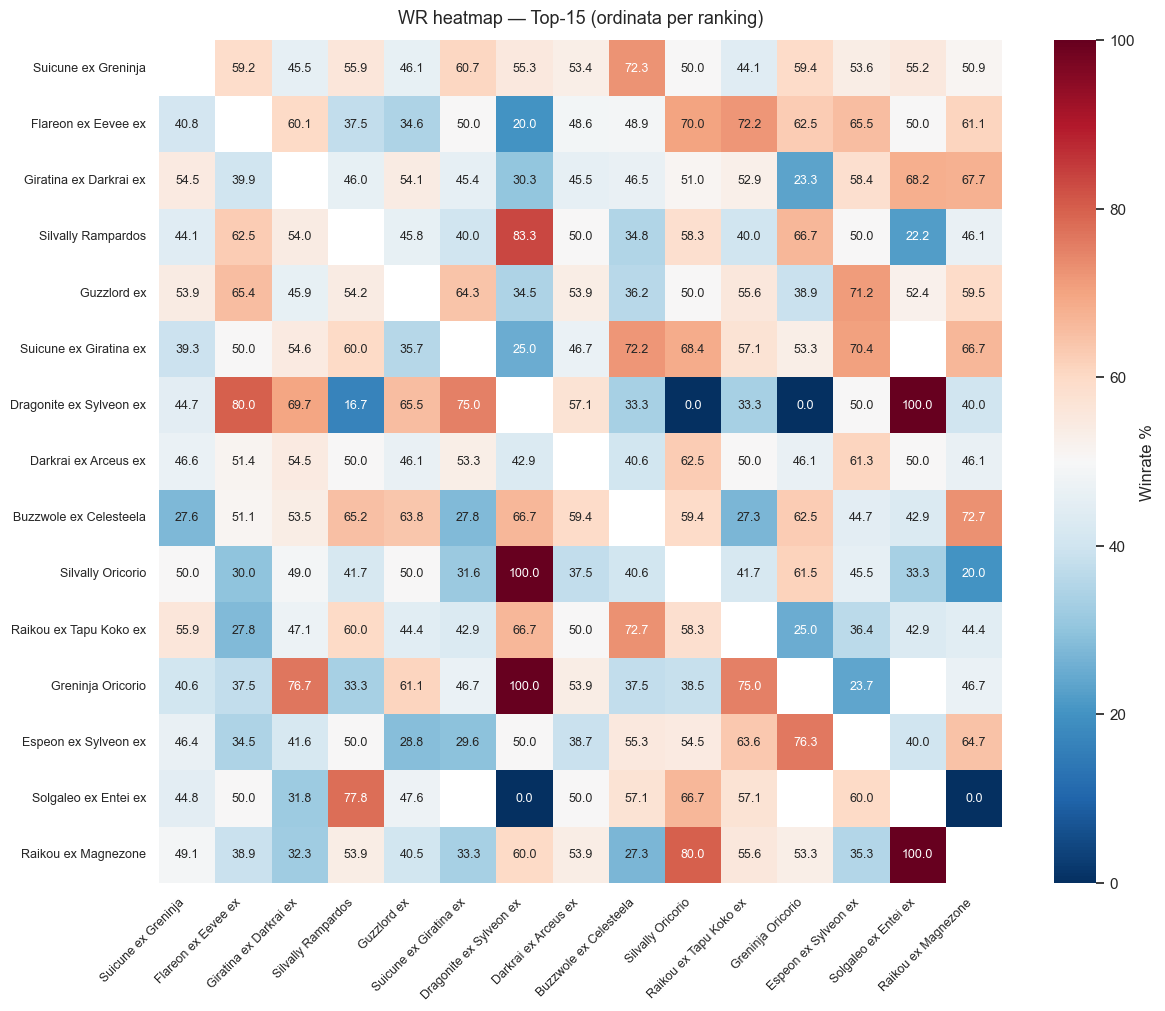

In [33]:
# === Heatmap WR — opzioni pronte all'uso =====================================
from utils.display import show_wr_heatmap
from utils.io import _dest

# Directory di salvataggio per heatmap (route ufficiale)
heatmap_dir = _dest(PATHS, "heatmap_topN")  # 'paths' creato a inizio notebook con init_paths(BASE)

# 0) Default: Top-10, annotazioni con 1 decimale (fmt='.1f'), diagonale bianca
fig, ax, wr_sub = show_wr_heatmap(
    ranking,
    wr=wr,          # filtered_wr_latest già caricato come 'wr'
    top_n=15,       # clamp robusto tra 2 e len(ranking)
    annot=True,     # True per mostrare i valori
    fmt=".1f",
    save = True
)



# ── Varianti (scommenta UNA per volta) ───────────────────────────────────────

# 1) Top-15 con annotazioni intere e maschera triangolo superiore (meno clutter)
# show_wr_heatmap(ranking, wr=wr, top_n=15, annot=True, fmt=".0f", mask_mirror=True)

# 2) Tutto il ranking; figura più ampia
# show_wr_heatmap(ranking, wr=wr, top_n=len(ranking), figsize=(14, 12), annot=False)

# 3) Colormap alternativa (vlag), centrata su 50%
# show_wr_heatmap(ranking, wr=wr, top_n=20, cmap="vlag", annot=True, fmt=".1f")

# 4) SALVA — duale: wr_heatmap_latest + wr_heatmap_T{T}_<timestamp>.png
# show_wr_heatmap(ranking, wr=wr, top_n=15, annot=True, save=True, save_dir=heatmap_dir)

# 5) SALVA — tutto il ranking, con annotazioni intere
# show_wr_heatmap(ranking, wr=wr, top_n=len(ranking), annot=True, fmt=".0f", save=True, save_dir=heatmap_dir)


In [34]:
# === MARS — Matchup Report (Excel, per-deck) — styling + banner + riordino ===
import logging, importlib
import pandas as pd

# ricarica moduli (prendi le patch più recenti di writer/styling e report)
import utils.io as uio, mars.report as r
importlib.reload(uio); importlib.reload(r)

from utils.io import _dest
from mars.meta import blend_meta
from mars.auto_k_cv import auto_k_cv

log = logging.getLogger("ptcgp")

# 1) Contratti latest
p_filtered_wr = _dest(PATHS, "filtered_wr") / "filtered_wr_latest.csv"
p_score_flat  = _dest(PATHS, "matchup_score_table") / "score_latest.csv"
p_ranking     = _dest(PATHS, "mars_ranking")        / "mars_ranking_latest.csv"
p_top_meta    = _dest(PATHS, "top_meta_decklist")   / "top_meta_decklist_latest.csv"

filtered_wr = pd.read_csv(p_filtered_wr, index_col=0)
score_flat  = pd.read_csv(p_score_flat)
ranking_df  = pd.read_csv(p_ranking)
top_meta_df = pd.read_csv(p_top_meta) if p_top_meta.exists() else None

axis = list(filtered_wr.index)
log.info("Report: loaded contracts (T=%d).", len(axis))

# 2) Matrici W, L e N=W+L (coerenti con l'asse)
W = score_flat.pivot_table(index="Deck A", columns="Deck B", values="W", aggfunc="sum").reindex(index=axis, columns=axis)
L = score_flat.pivot_table(index="Deck A", columns="Deck B", values="L", aggfunc="sum").reindex(index=axis, columns=axis)
N = (W.fillna(0.0) + L.fillna(0.0)).reindex(index=axis, columns=axis)

# 3) p(B) e K (stessa logica della pipeline): usa N per il blend del meta
p_weights, meta_info = blend_meta(axis, N, top_meta_df, mars_cfg)
K_used = float(auto_k_cv(W, L, N, mars_cfg)["K_used"])
log.info("Report: K_used=%.3f | gamma=%s", K_used, meta_info.get("gamma"))

# 4) Tutto-in-uno: per-deck + 00_Legenda (solo banner) + 01_Summary + styling + riordino
versioned_path, latest_path, meta = r.write_pairs_by_deck_report(
    ranking_df=ranking_df,
    filtered_wr=filtered_wr,
    n_dir=N,                       # W+L direzionali
    p_blend=p_weights,             # pesi meta-blend
    K_used=K_used,
    score_flat=score_flat,         # per WR_real_% e conteggi
    mu=mars_cfg.MU,
    gamma=meta_info.get("gamma"),
    include_posterior_se=False,    # niente SE_dir_% nei fogli per-deck
    include_binom_se=True,
    include_counts=True,
    include_self_row=True,
    include_weight_col=False,      # niente w_A(B)_% 
    include_mas_contrib_col=False, # niente MAS_contrib_pp
    out_dir=_dest(PATHS, "report"),
    base_name=f"pairs_by_deck_T{len(axis)}_MARS",
)

log.info("Report scritto: versioned=%s | latest=%s", versioned_path, latest_path)


INFO | ptcgp | Report: loaded contracts (T=25).
INFO | ptcgp | Report: K_used=3.674 | gamma=0.3
INFO | utils.io | Excel versionato (styled): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_MARS_20250916_185103.xlsx
INFO | utils.io | Excel latest (styled): c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_MARS_latest.xlsx
INFO | ptcgp | Report scritto e riordinato | versioned=c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_MARS_20250916_185103.xlsx | latest=c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs\RankingData\MARS\Report\pairs_by_deck_T25_MARS_latest.xlsx
INFO | ptcgp | Report scritto: versioned=c:\Users\visen\OneDrive\Documenti\Archivio\Pokèmon\PTCGP\DataAnalysis\ptcgp_ranking\outputs